In [ ]:
import pandas as pd
import torch

In [ ]:
torch.manual_seed(42)
# It ensures that random numbers generated by PyTorch are the same every time you run the code.

In [ ]:
# check for gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

Using Device: cuda


In [ ]:
df = pd.read_csv("https://drive.google.com/uc?export=download&id=13R1Nyui96pWZM6diATH2S2AiMlwQXmHl")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,125,72,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,0,2,0,0,210,228,228,233,0,0,0,0,0,0,0,0,0,31,81,133,184,201,190,117,0,0,2,1,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,43,117,34,15,24,33,117,80,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,51,144,152,...,157,158,161,148,159,58,0,6,0,0,0,0,0,0,0,0,0,4,0,60,143,143,148,146,152,152,148,148,147,145,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,0,0,0,2,0,33,114,37,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,11,17,13,13,11,10,7,5,5,5,7,0,0,0,1,0,0,41,69,88,86,94,106,114,118,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,0,2,0,58,145,114,10,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,...,165,153,155,134,143,172,215,62,0,0,0,0,0,0,0,0,10,190,178,194,209,211,209,205,211,215,213,217,225,228,213,203,174,151,188,10,0,0,0,0


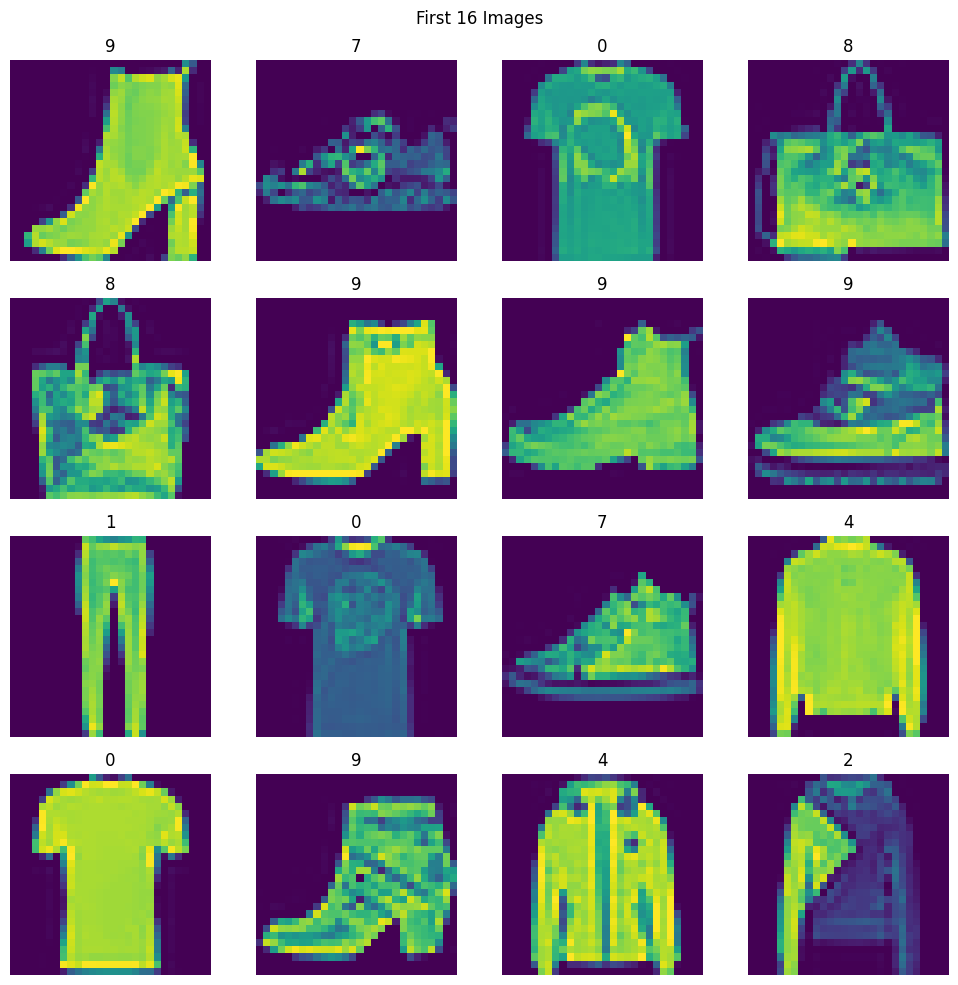

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i + 1)

    img = df.iloc[i, 1:].values.reshape(28, 28)
    plt.imshow(img)
    plt.title(df.iloc[i, 0])
    plt.axis("off")

plt.suptitle("First 16 Images")
plt.tight_layout()
plt.show()

# train test split

In [ ]:
x = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [ ]:
x

array([[  0,   0,   0, ..., 165,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [ ]:
y

array([9, 7, 0, ..., 8, 4, 8])

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state=42)

In [ ]:
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from PIL import Image
import numpy as np

In [ ]:
# Define Transform (Image Preprocessing)
  # VGG16 expects:
  # 3-channel image (RGB)
  # Size 224×224
  # Normalized with ImageNet mean & std

transform = transforms.Compose([
    transforms.Resize((224, 224)),     # Resize image
    transforms.ToTensor(),             # Convert to tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
# Custom Dataset
  # Reshape to 28×28
  # Convert grayscale → RGB
  # Apply transform
  # Return image + label

class SimpleDataset(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):

        img = self.X[index].reshape(28, 28).astype(np.uint8)

        # convert 1 channel → 3 channel
        img = np.stack([img]*3, axis=-1)

        img = Image.fromarray(img)
        img = transform(img)

        label = torch.tensor(self.y[index], dtype=torch.long)

        return img, label

In [ ]:
# Create DataLoader
train_dataset = SimpleDataset(x_train, y_train)
test_dataset = SimpleDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# Load Pretrained Model

model = models.vgg16(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Freeze Feature Extractor We don’t train convolution layers.

for param in model.features.parameters():
    param.requires_grad = False

In [ ]:
# Replace Final Classifier Original VGG16 outputs 1000 classes. We change it to 10 classes.

model.classifier = nn.Sequential(
    nn.Linear(25088, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Loss and Optimizer We train only classifier parameters.

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

In [ ]:
# Training Loop

epochs = 5

for epoch in range(epochs):

    model.train()
    total_loss = 0

    for images, labels in train_loader:

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader)}")

Epoch 1 | Loss: 0.48350325723489124
Epoch 2 | Loss: 0.12516381221512954
Epoch 3 | Loss: 0.034436414415637655
Epoch 4 | Loss: 0.014969161378685385
Epoch 5 | Loss: 0.004721247836229547


In [ ]:
# Evaluation
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print("Test Accuracy:", accuracy)

Test Accuracy: 0.8966666666666666


In [ ]:
def get_accuracy(model, loader, device):

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    return correct / total

train_accuracy = get_accuracy(model, train_loader, device)
test_accuracy = get_accuracy(model, test_loader, device)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy :", test_accuracy)
print("Difference    :", train_accuracy - test_accuracy)

Train Accuracy: 1.0
Test Accuracy : 0.8966666666666666
Difference    : 0.10333333333333339


In [ ]:
# Code for getting y_pred & y_test
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n")
print(cm)

Confusion Matrix:

[[116   0   3   7   1   0  18   0   1   0]
 [  0 119   0   2   1   0   0   0   0   0]
 [  2   0 106   3   3   0   5   0   0   0]
 [  2   0   0 109   6   0   9   0   0   0]
 [  1   0   4   7 111   0  14   0   0   0]
 [  0   0   0   0   0 108   0   3   0   2]
 [  7   0   6   6   5   0 103   0   1   0]
 [  0   0   0   0   0   0   0 107   0   4]
 [  0   0   0   0   0   0   0   0 111   0]
 [  0   0   0   0   0   1   0   0   0  86]]


In [ ]:
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds))


Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.79      0.85       146
           1       1.00      0.98      0.99       122
           2       0.89      0.89      0.89       119
           3       0.81      0.87      0.84       126
           4       0.87      0.81      0.84       137
           5       0.99      0.96      0.97       113
           6       0.69      0.80      0.74       128
           7       0.97      0.96      0.97       111
           8       0.98      1.00      0.99       111
           9       0.93      0.99      0.96        87

    accuracy                           0.90      1200
   macro avg       0.91      0.90      0.90      1200
weighted avg       0.90      0.90      0.90      1200



In [ ]:
# Save Final Model for application development